In [1]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.modeling import models, fitting
from photutils import isophote, aperture_photometry
from photutils import CircularAperture, EllipticalAperture, EllipticalAnnulus
from photutils.isophote import EllipseGeometry, Ellipse
import ipywidgets
# from luminosity import surface_brightness, kpc2pix

In [2]:
def bounding_box(snap):
    unit = snap['pos'].units
    for coord in 'x y z'.split():
        print("{}: {:10.2f}, {:10.2f} ({})".format(coord, snap[coord].min(), snap[coord].max(), unit))
    return [(float(snap[coord].min()), float(snap[coord].max())) for coord in 'x y z'.split()]

In [3]:
def fit_sersic(img, r_eff, n, ellip, theta):
    res_x, res_y = img.shape
    y, x = np.mgrid[:res_x, :res_y]
    s_init = models.Sersic2D(r_eff=r_eff, n=n, x_0=res_x/2, y_0=res_y/2, ellip=ellip, theta=theta,
                         fixed={'amplitude':False, 'n':False, 'ellip':False, 'x_0':True, 'y_0':True},
                         bounds={})#'theta':(0, np.pi)})
    fit_s = fitting.SLSQPLSQFitter()
    # notnans = np.isfinite(img)
    # sersic = fit_s(s_init, x[notnans], y[notnans], img[notnans])
    sersic = fit_s(s_init, x, y, img)
    return sersic

In [4]:
def plot_angmom(snap, ax):
    """Plot the projected angular momentum on the map on `ax`, after having
    normalized it to one. It means that short arrows plotted means L almost
    aligned with line-of-sight-direction."""
    L = pynbody.analysis.angmom.ang_mom_vec(snap)
    print("L:", L)
    norm = np.linalg.norm(L)
    ax.arrow(0, 0, L[0]/norm, L[1]/norm, head_width=0.2, head_length=.2, color='red');

In [5]:
snap = "/home/michele/sim/MoRIA/M1-10_Verbeke2017/M10sim41001/snapshot_0036"
s = pynbody.load(snap)

In [6]:
max_boxsize = 4000

In [7]:
s.properties['boxsize'] = pynbody.units.Unit("{} kpc".format(max_boxsize))

In [8]:
width = 10
resolution = 500

In [9]:
pynbody.analysis.halo.center(s.g)#, vel=False)
subsnap = s[pynbody.filt.Cuboid('{} kpc'.format(-width*1.1))]

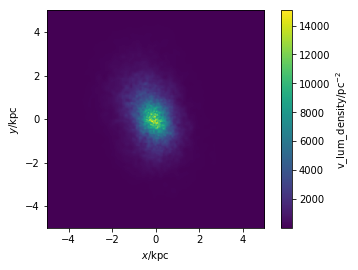

In [10]:
fig, ax = plt.subplots()
band='v'
lum_density_name = band + '_lum_density'
sun_abs_mag = {'u':5.56,'b':5.45,'v':4.8,'r':4.46,'i':4.1,'j':3.66,'h':3.32,'k':3.28}[band]
s.s[lum_density_name] = (10 ** (-0.4 * (s.s[band + "_mag"] - sun_abs_mag))) * s.s['rho'] / s.s['mass']

s.s[lum_density_name].units = s.s['rho'].units/s.s['mass'].units

pynbody.plot.sph.image(s.s, qty=lum_density_name, units='pc^-2',
                             noplot=False, width=width, resolution=resolution, log=False);

In [12]:
pynbody.analysis.luminosity.halo_mag(s.s,band='v')

SimArray(-21.64656986)

In [11]:
def surface_brightness(snap, band='v', width=10, resolution=500, mag_filter=29, gaussian_sigma=None, lum_pc2=True,
                       subplot=None, show_cbar=True, center=False, title=None, cmap_name='viridis', contour=0, **kwargs):
    from luminosity import convert_to_mag_arcsec2, kpc2pix
    if subplot:
        fig, ax = subplot.figure, subplot
    else:
        fig, ax = plt.gcf(), plt.gca()

    if center:
        pynbody.analysis.halo.center(snap.s, vel=False);

    lum_density_name = band + '_lum_density'
    sun_abs_mag = {'u':5.56,'b':5.45,'v':4.8,'r':4.46,'i':4.1,'j':3.66,'h':3.32,'k':3.28}[band]
    snap.s[lum_density_name] = (10 ** (-0.4 * (snap.s[band + "_mag"] - sun_abs_mag))) * snap.s['rho'] / snap.s['mass']

    snap.s[lum_density_name].units = snap.s['rho'].units/snap.s['mass'].units

    pc2 = pynbody.plot.sph.image(snap.s, qty=lum_density_name, units='pc^-2',
                                 noplot=True, width=width, resolution=resolution, **kwargs)
    if lum_pc2:
        sb = pc2
    else:
        sb = convert_to_mag_arcsec2(pc2)

    # Apply the gaussian smoothing
    if gaussian_sigma is not None:
        sigma_pix = kpc2pix(gaussian_sigma, width, resolution)
        sb = gaussian_filter(sb, sigma_pix)

    # Filter above a certain magnitude
    if not lum_pc2 and mag_filter is not None:
        sb[sb > mag_filter] = np.nan

    cmap = plt.get_cmap(cmap_name)
    cmap.set_bad('black')

    # Do the plot
    log = kwargs.get('log', False)
    if log and lum_pc2:
        sb = np.log10(sb)

    extent = (-width/2, width/2, -width/2, width/2)
    img = ax.imshow(sb, cmap=cmap, extent=extent, origin='lower')

    if show_cbar:
        cbar = ax.figure.colorbar(img);
        if lum_pc2:
            cbar.set_label('${}I$ [L$_{{\odot,{}}}$/pc$^2$]'.format("Log" if log else "", band.upper()));
        else:
            cbar.set_label('$\mu_{}$ [mag/arcsec$^2$]'.format(band.upper()));
    ax.set_xlabel('x/kpc')
    ax.set_ylabel('y/kpc')
    if not lum_pc2 and contour:
        nisophotes = contour
        levels = np.linspace(sb.min(), sb.max(), nisophotes, dtype=np.int)
        cont = ax.contour(sb, levels=levels, cmap='flag', extent=extent)
        ax.clabel(cont, inline=1, fmt='%1.0f');
    if title is not None:
        ax.set_title(title)
    plt.draw()
    return sb

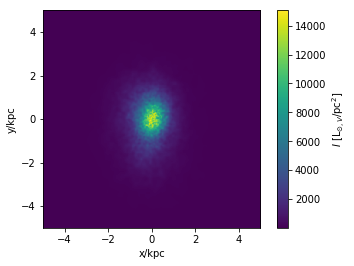

In [12]:
pynbody.analysis.angmom.sideon(subsnap.s)
# subsnap.rotate_y(90)
fig, ax = plt.subplots()
sb = surface_brightness(subsnap.s, width=width, resolution=resolution, lum_pc2=True, log=False,
                        mag_filter=None, subplot=ax)

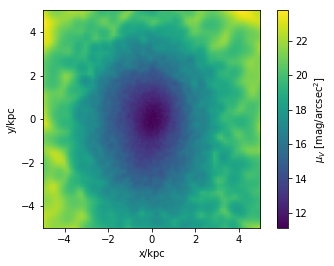

In [13]:
fig, ax = plt.subplots()
sb = surface_brightness(subsnap.s, width=width, resolution=resolution, lum_pc2=False, log=False,
                        mag_filter=None, subplot=ax)

In [14]:
pynbody.analysis.luminosity.halo_mag(s)

SimArray(-21.64656986)

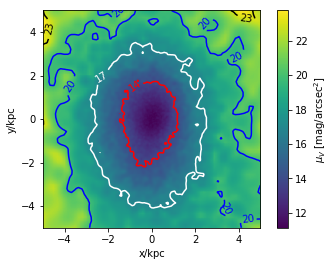

In [15]:
fig, ax = plt.subplots()
extent = (-width/2, width/2, -width/2, width/2)
sb = surface_brightness(subsnap.s, width=width, resolution=resolution, lum_pc2=False, log=False, 
                        mag_filter=None, subplot=ax, contour=5)
L = pynbody.analysis.angmom.ang_mom_vec(subsnap.s)
# plot_angmom(subsnap.s, ax)